# SAMPLING SIGNALS WITH FINITE RATE OF INNOVATION

In [37]:
# %% LOAD LIBRARIES

import os
import numpy as np

from matplotlib import style
from matplotlib import rcParams
from matplotlib import pyplot as plt

import fri_utils
import fri_algos

In [38]:
# %% PLOT SETTINGS

plt.style.use(['science','ieee'])

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["cm"],
    "mathtext.fontset": "cm",
    "font.size": 24})

os.makedirs('./../figures/vetterli_2001/', exist_ok=True)
path = './../figures/vetterli_2001/'

In [39]:
# %% GENERATE SIGNAL

np.random.seed(723)

K = 5                                                                       # Number of Diracs
TAU = 1                                                                     # Period of the signal

ak = np.sign(np.random.rand(K))*(1.0 + (np.random.randn(K) - 0.5)/1.0)      # Set amplitudes
tk = np.sort(np.random.rand(K)*TAU)                                         # Set shifts

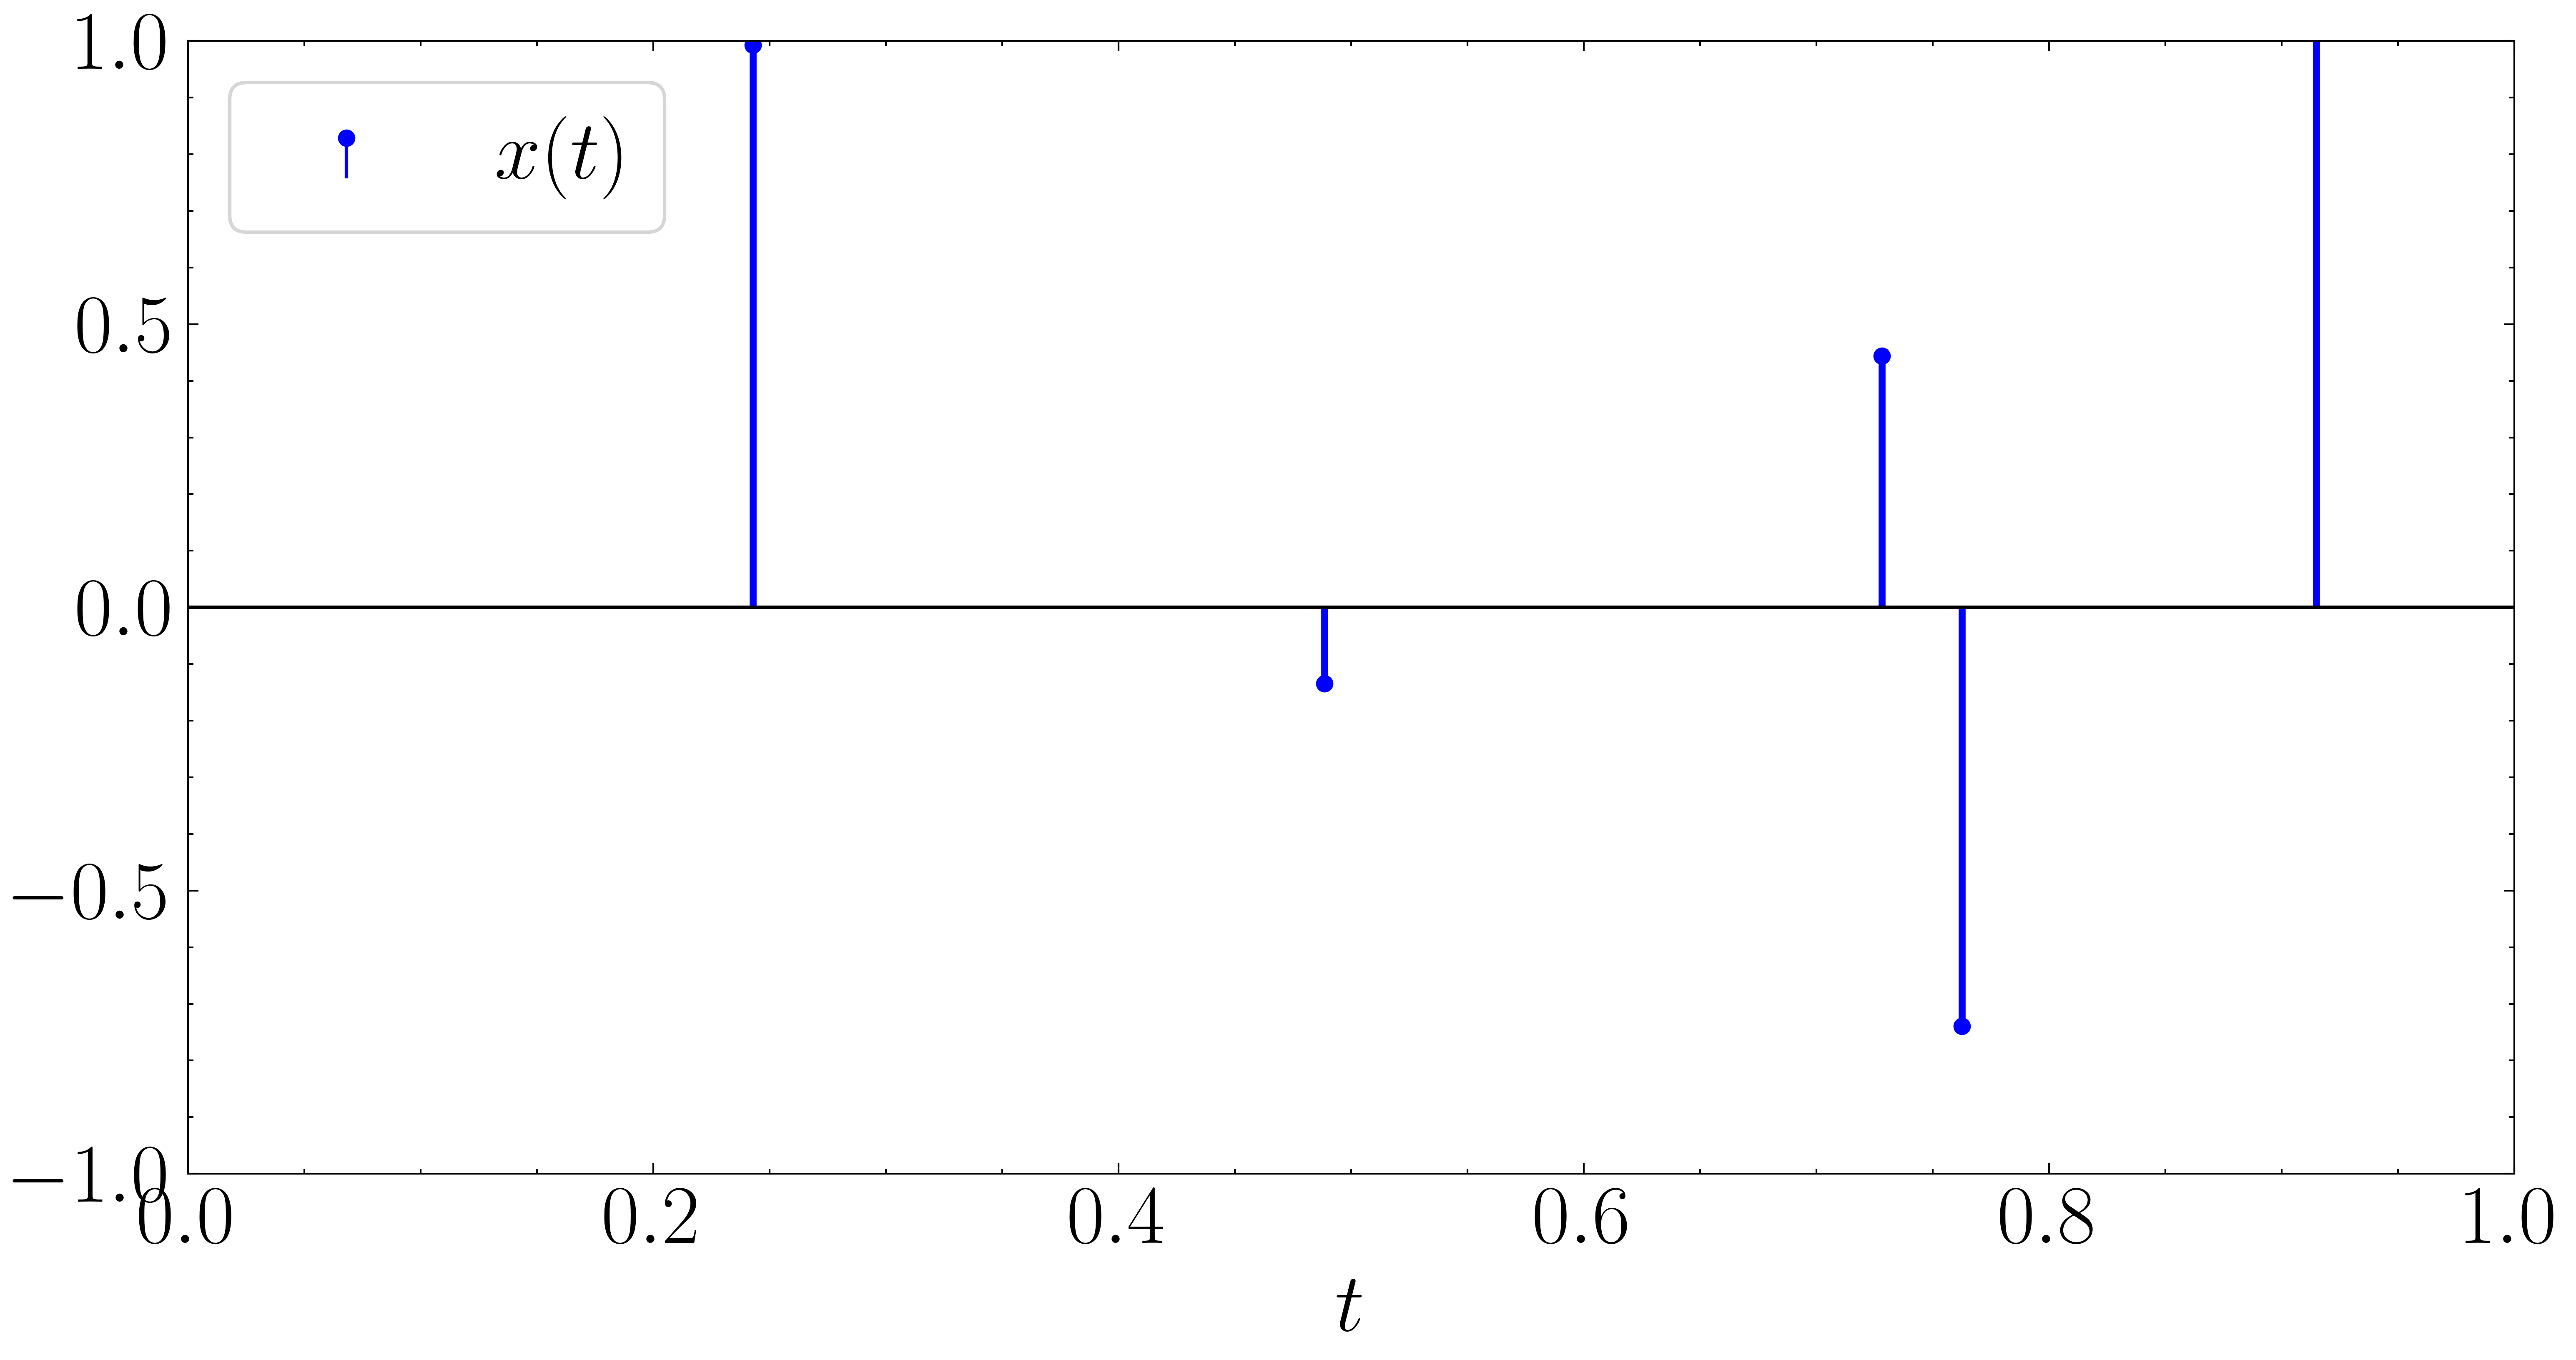

In [40]:
# %% PLOT ORIGINAL SIGNAL

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_hline(0, ax=ax)
fri_utils.plot_diracs(tk, ak, ax=ax, xaxis_label=r'$t$', legend_label=r'$x(t)$',
    xlimits=[0,TAU])

In [41]:
# %% KERNEL-BASED SAMPLING

# Define sampling parameters
M = K                           # Number of Fourier measurements
B = (2. * M + 1)/TAU            # Bandwidth of the Dirichlet kernel
N = 2 * M + 1                   # Number of temporal samples

# Filtered signal
t_continuous = np.linspace(0,TAU,1000)
tl_grid, tk_grid = np.meshgrid(tk, t_continuous)
filtered_signal = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

# Temporal samples
t_unif = np.arange(0, N, dtype=float)*TAU/N
tl_grid, tk_grid = np.meshgrid(tk, t_unif)
samples_unif = np.inner(ak, fri_utils.dirichlet(tk_grid - tl_grid, B, TAU))

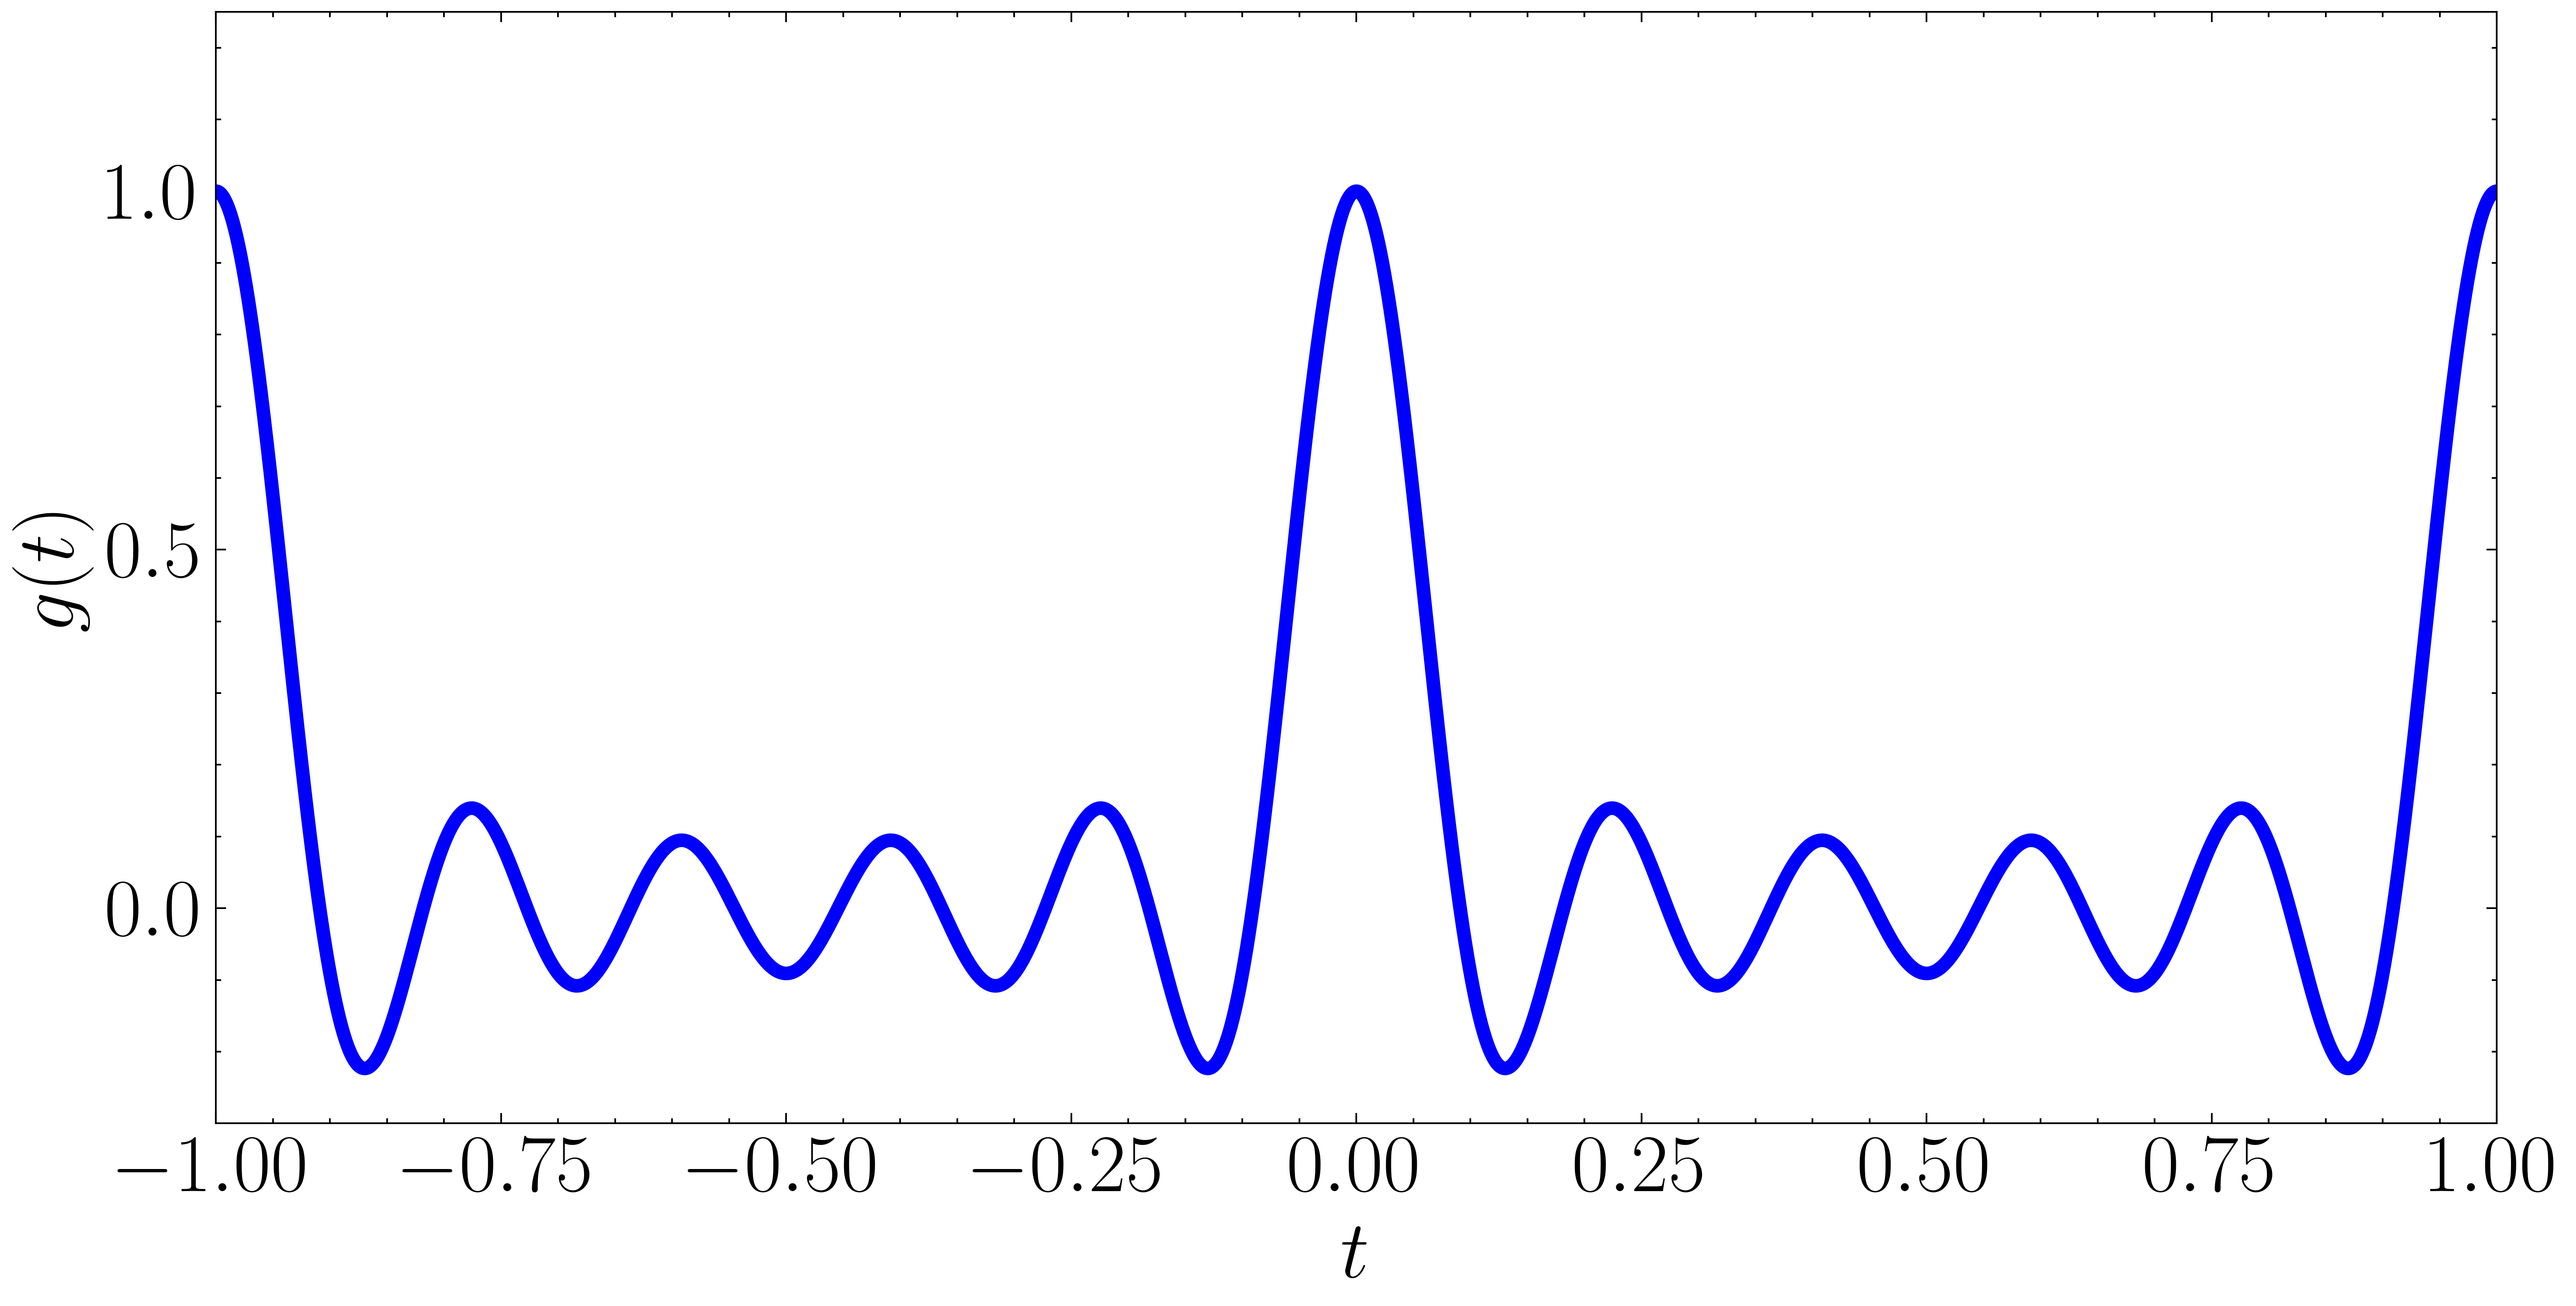

In [51]:
# %% PLOT SAMPLING KERNEL

t_kernel = np.linspace(-1,1,10000)
sampling_kernel = fri_utils.dirichlet(np.linspace(-1,1,10000), B, TAU)
fri_utils.plot_signal(t_kernel, sampling_kernel, line_width=4,
    xlimits=[-1,1], ylimits=[-.3,1.25], xaxis_label=r'$t$', yaxis_label=r'$g(t)$',
    show=True, save=path+'dirichletKernel')

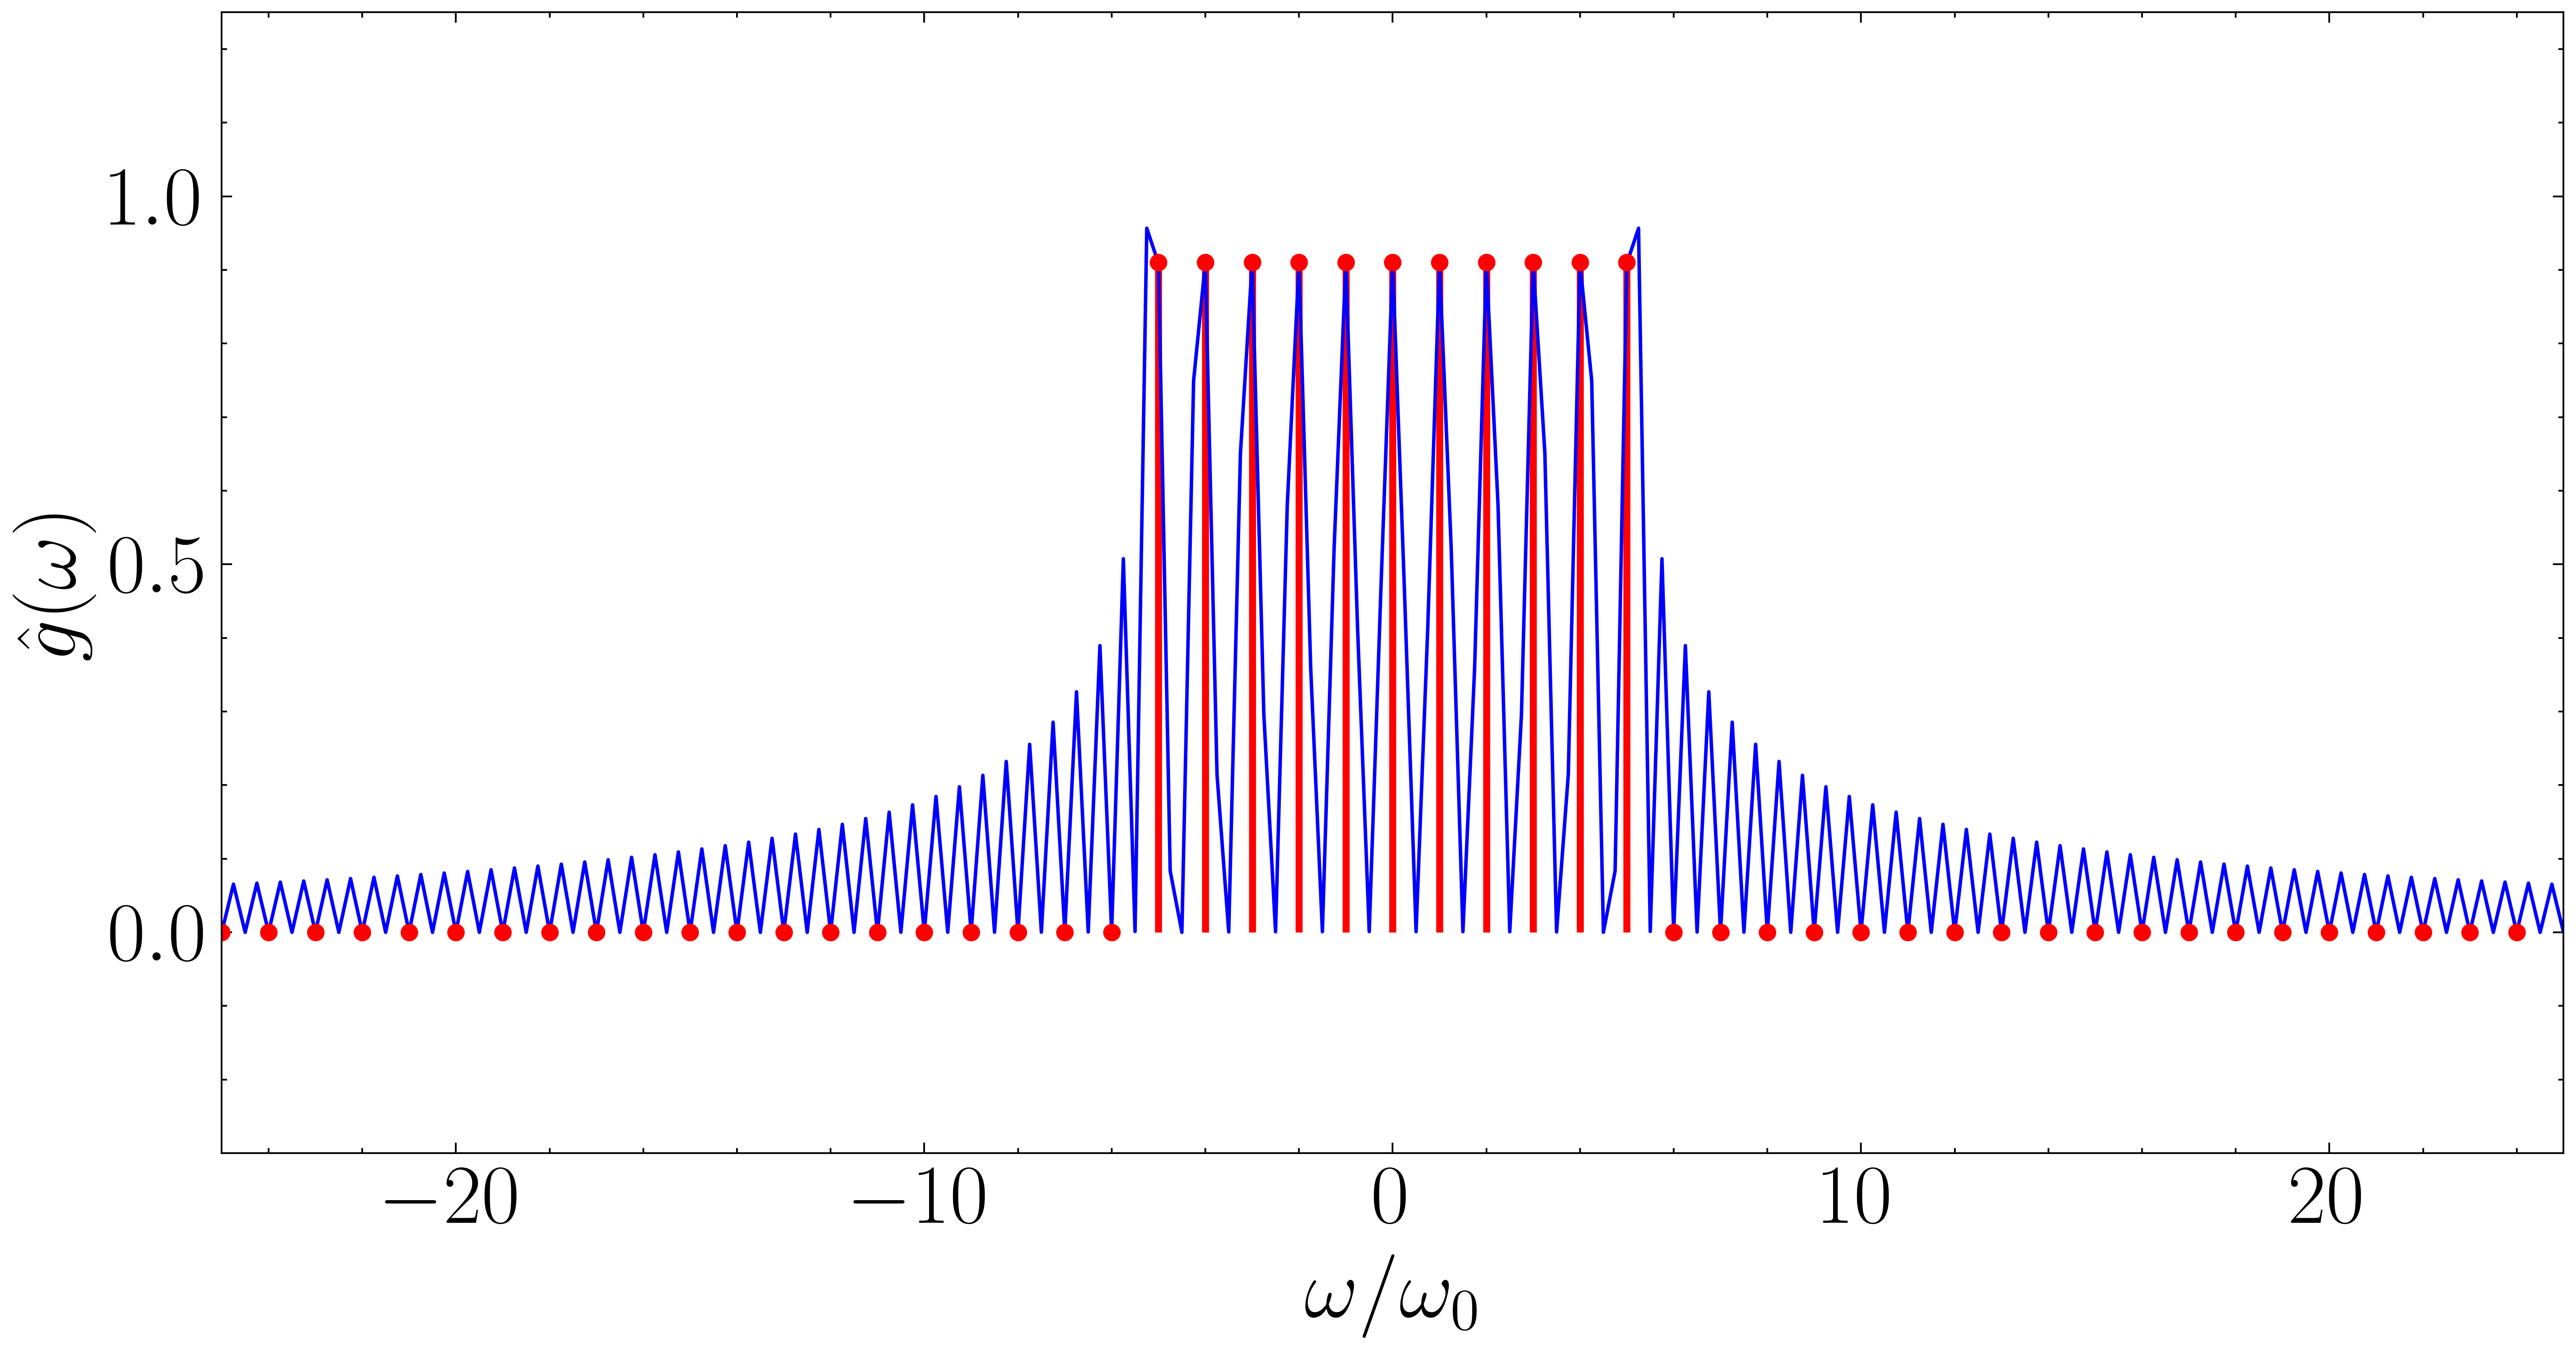

In [151]:
# %% SAMPLING KERNEL IN THE FOURIER DOMAIN

Fs = len(t_kernel) / 2
N = 20000
sampling_kernel_spectrum = np.abs(np.fft.fftshift(np.fft.fft(sampling_kernel,N))) / 1000
freqz = Fs / N * np.arange(-int(N/2),int(N/2))

samples_freqz = np.arange(-25,25)
samples_spectrum = (np.abs(samples_freqz) <= 5) * sampling_kernel_spectrum[int(N/2)]

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_signal(freqz, sampling_kernel_spectrum, ax=ax, line_width=1)
fri_utils.plot_diracs(samples_freqz, samples_spectrum, ax=ax, plot_colour='red',
    xlimits=[-25,25], ylimits=[-.3,1.25], xaxis_label=r'$\omega/\omega_0$',
    yaxis_label=r'$\hat g(\omega)$', save=path+'dirichletKernelSpectrum')

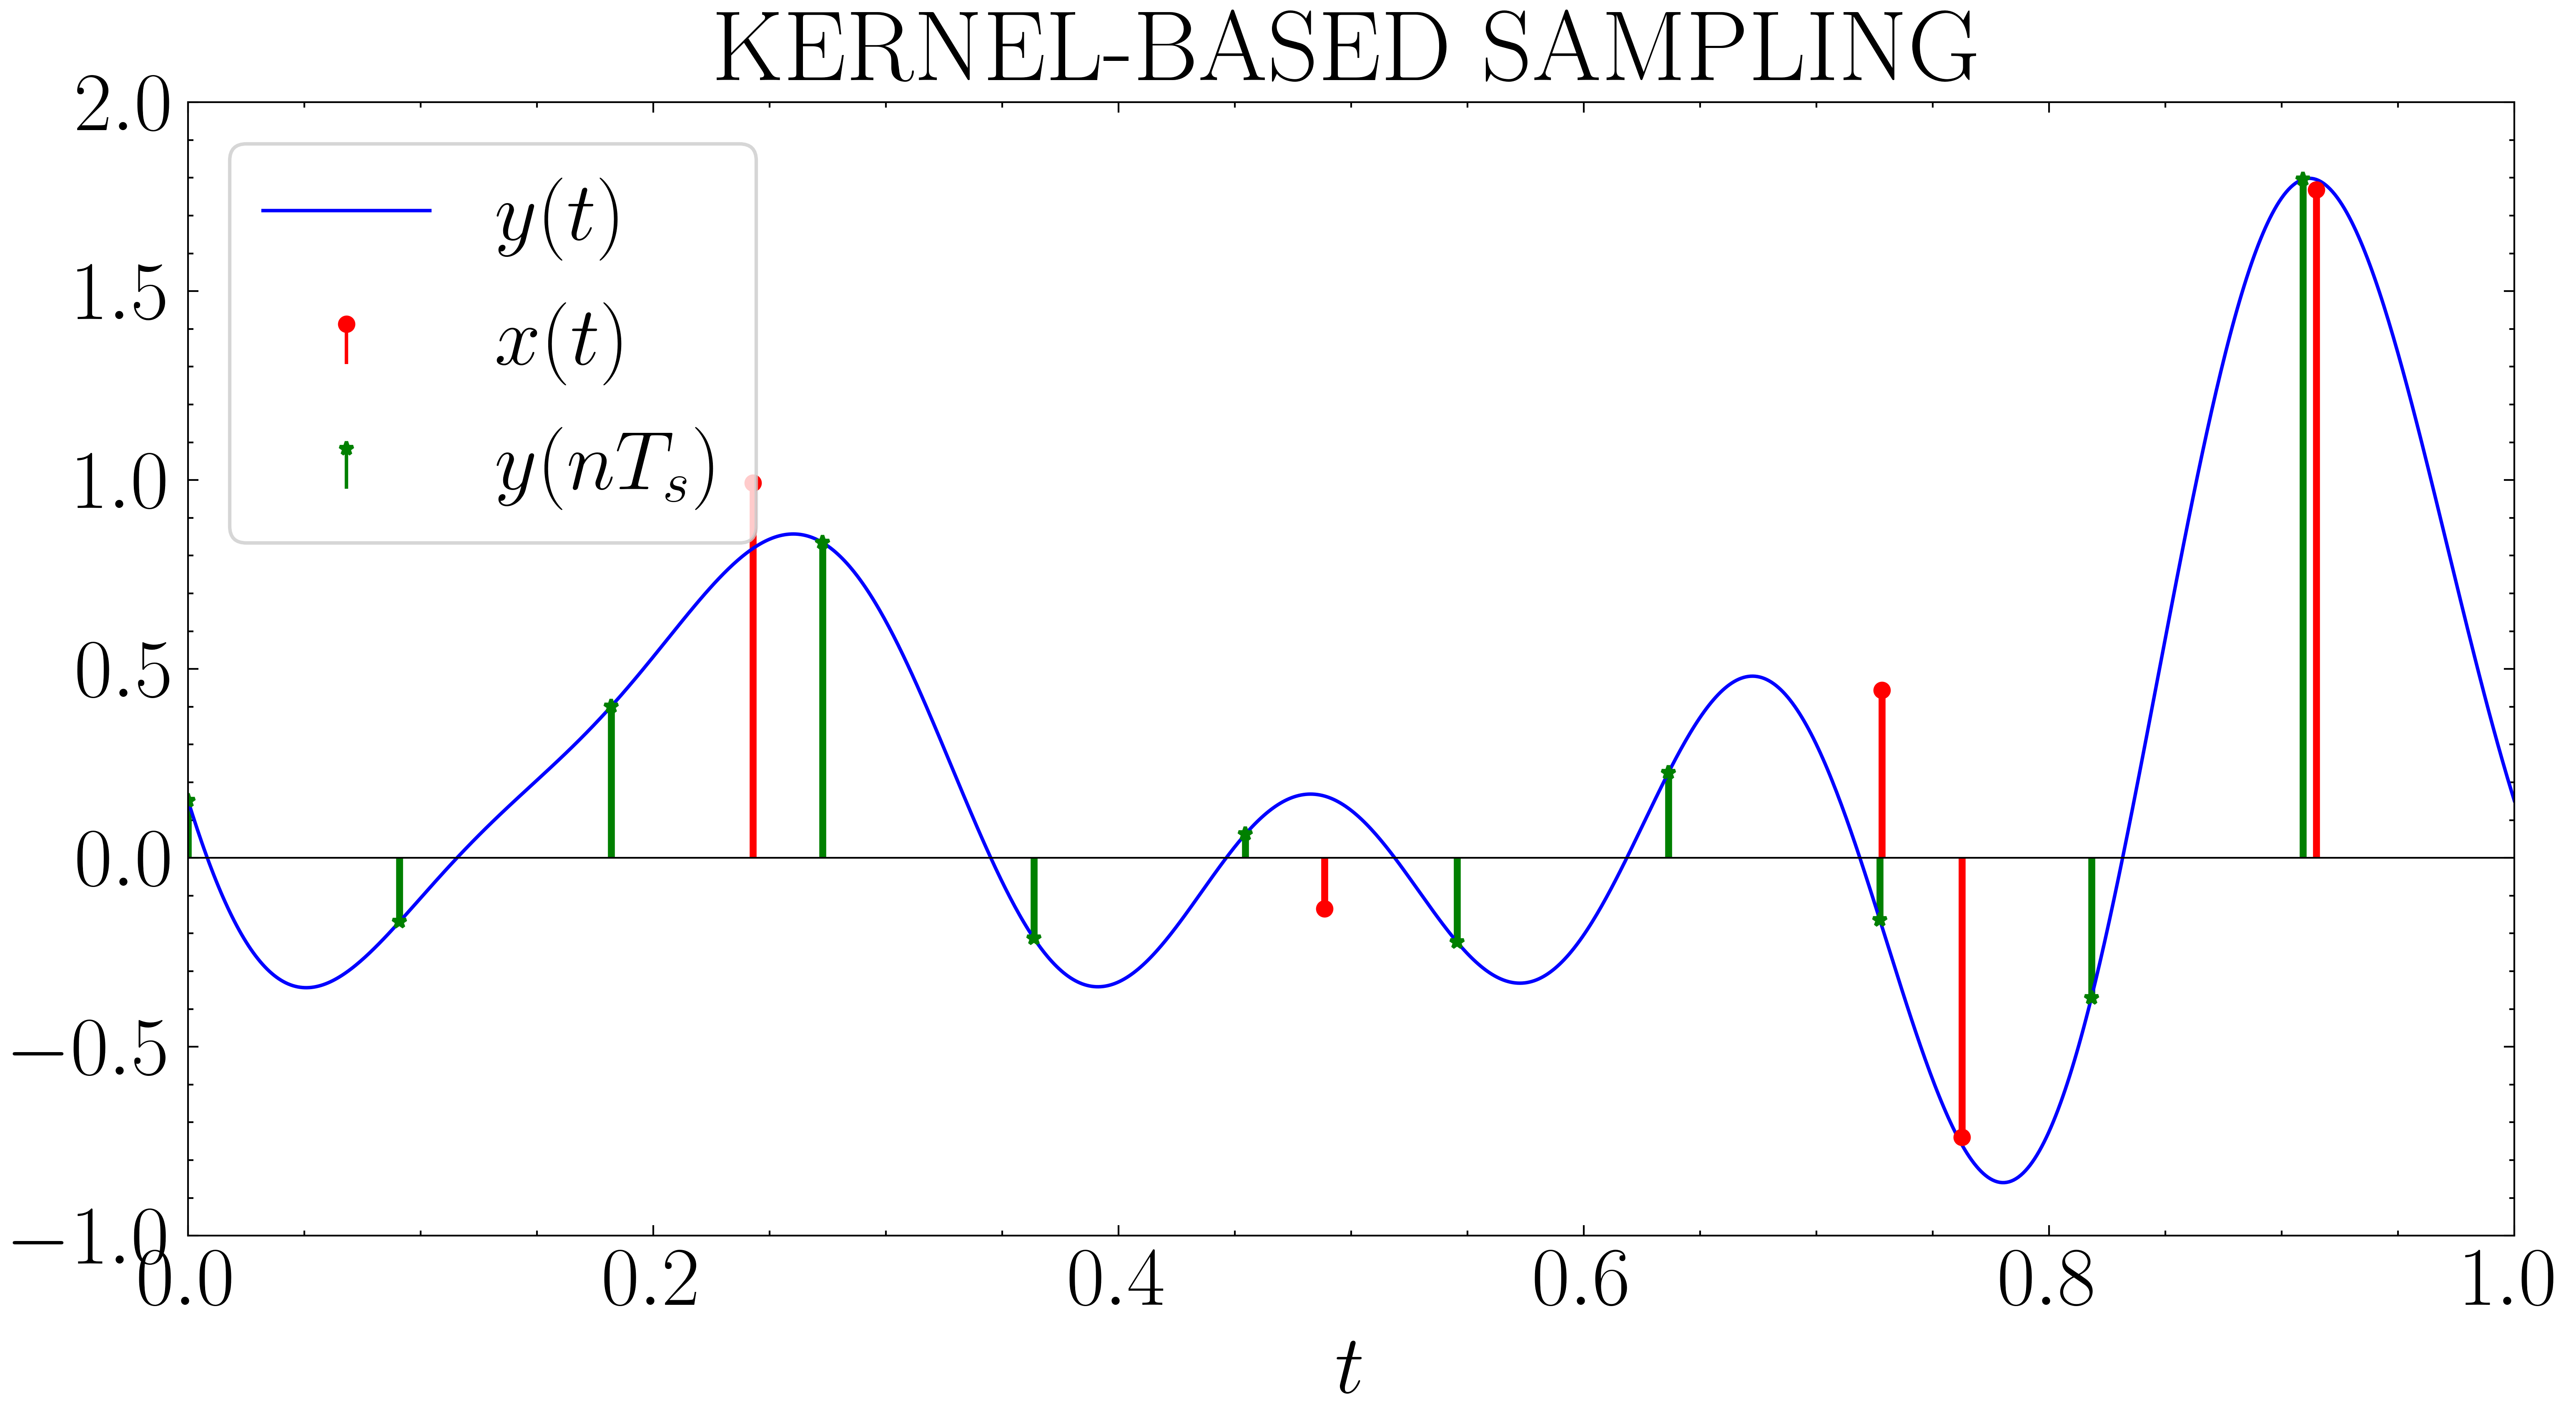

In [44]:
# %% PLOT SAMPLES

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_signal(t_continuous, filtered_signal, ax=ax, plot_colour='blue',
    legend_label=r'$y(t)$', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='red', legend_label=r'$x(t)$',
    show=False)
fri_utils.plot_diracs(t_unif, samples_unif, ax=ax, plot_colour='green',
    marker_style='*', legend_label=r'$y(nT_s)$', xaxis_label=r'$t$',
    title_text=r'KERNEL-BASED SAMPLING', xlimits=[0,TAU], ylimits=[-1,2],
    show=True, save=path+'sincUnifDiracSampling')

# Prony's Method

Diracs in the Fourier-domain appear when the time-domain signal is a sum of sinusoids. We expect the Fourier representation of the sum of Diracs in the time-domain to be a sum of complex exponentials. The sum of complex-epxponentials (SWCE) form is the starting point to high-resolution spectral estimation (HRSE) using Prony's method.

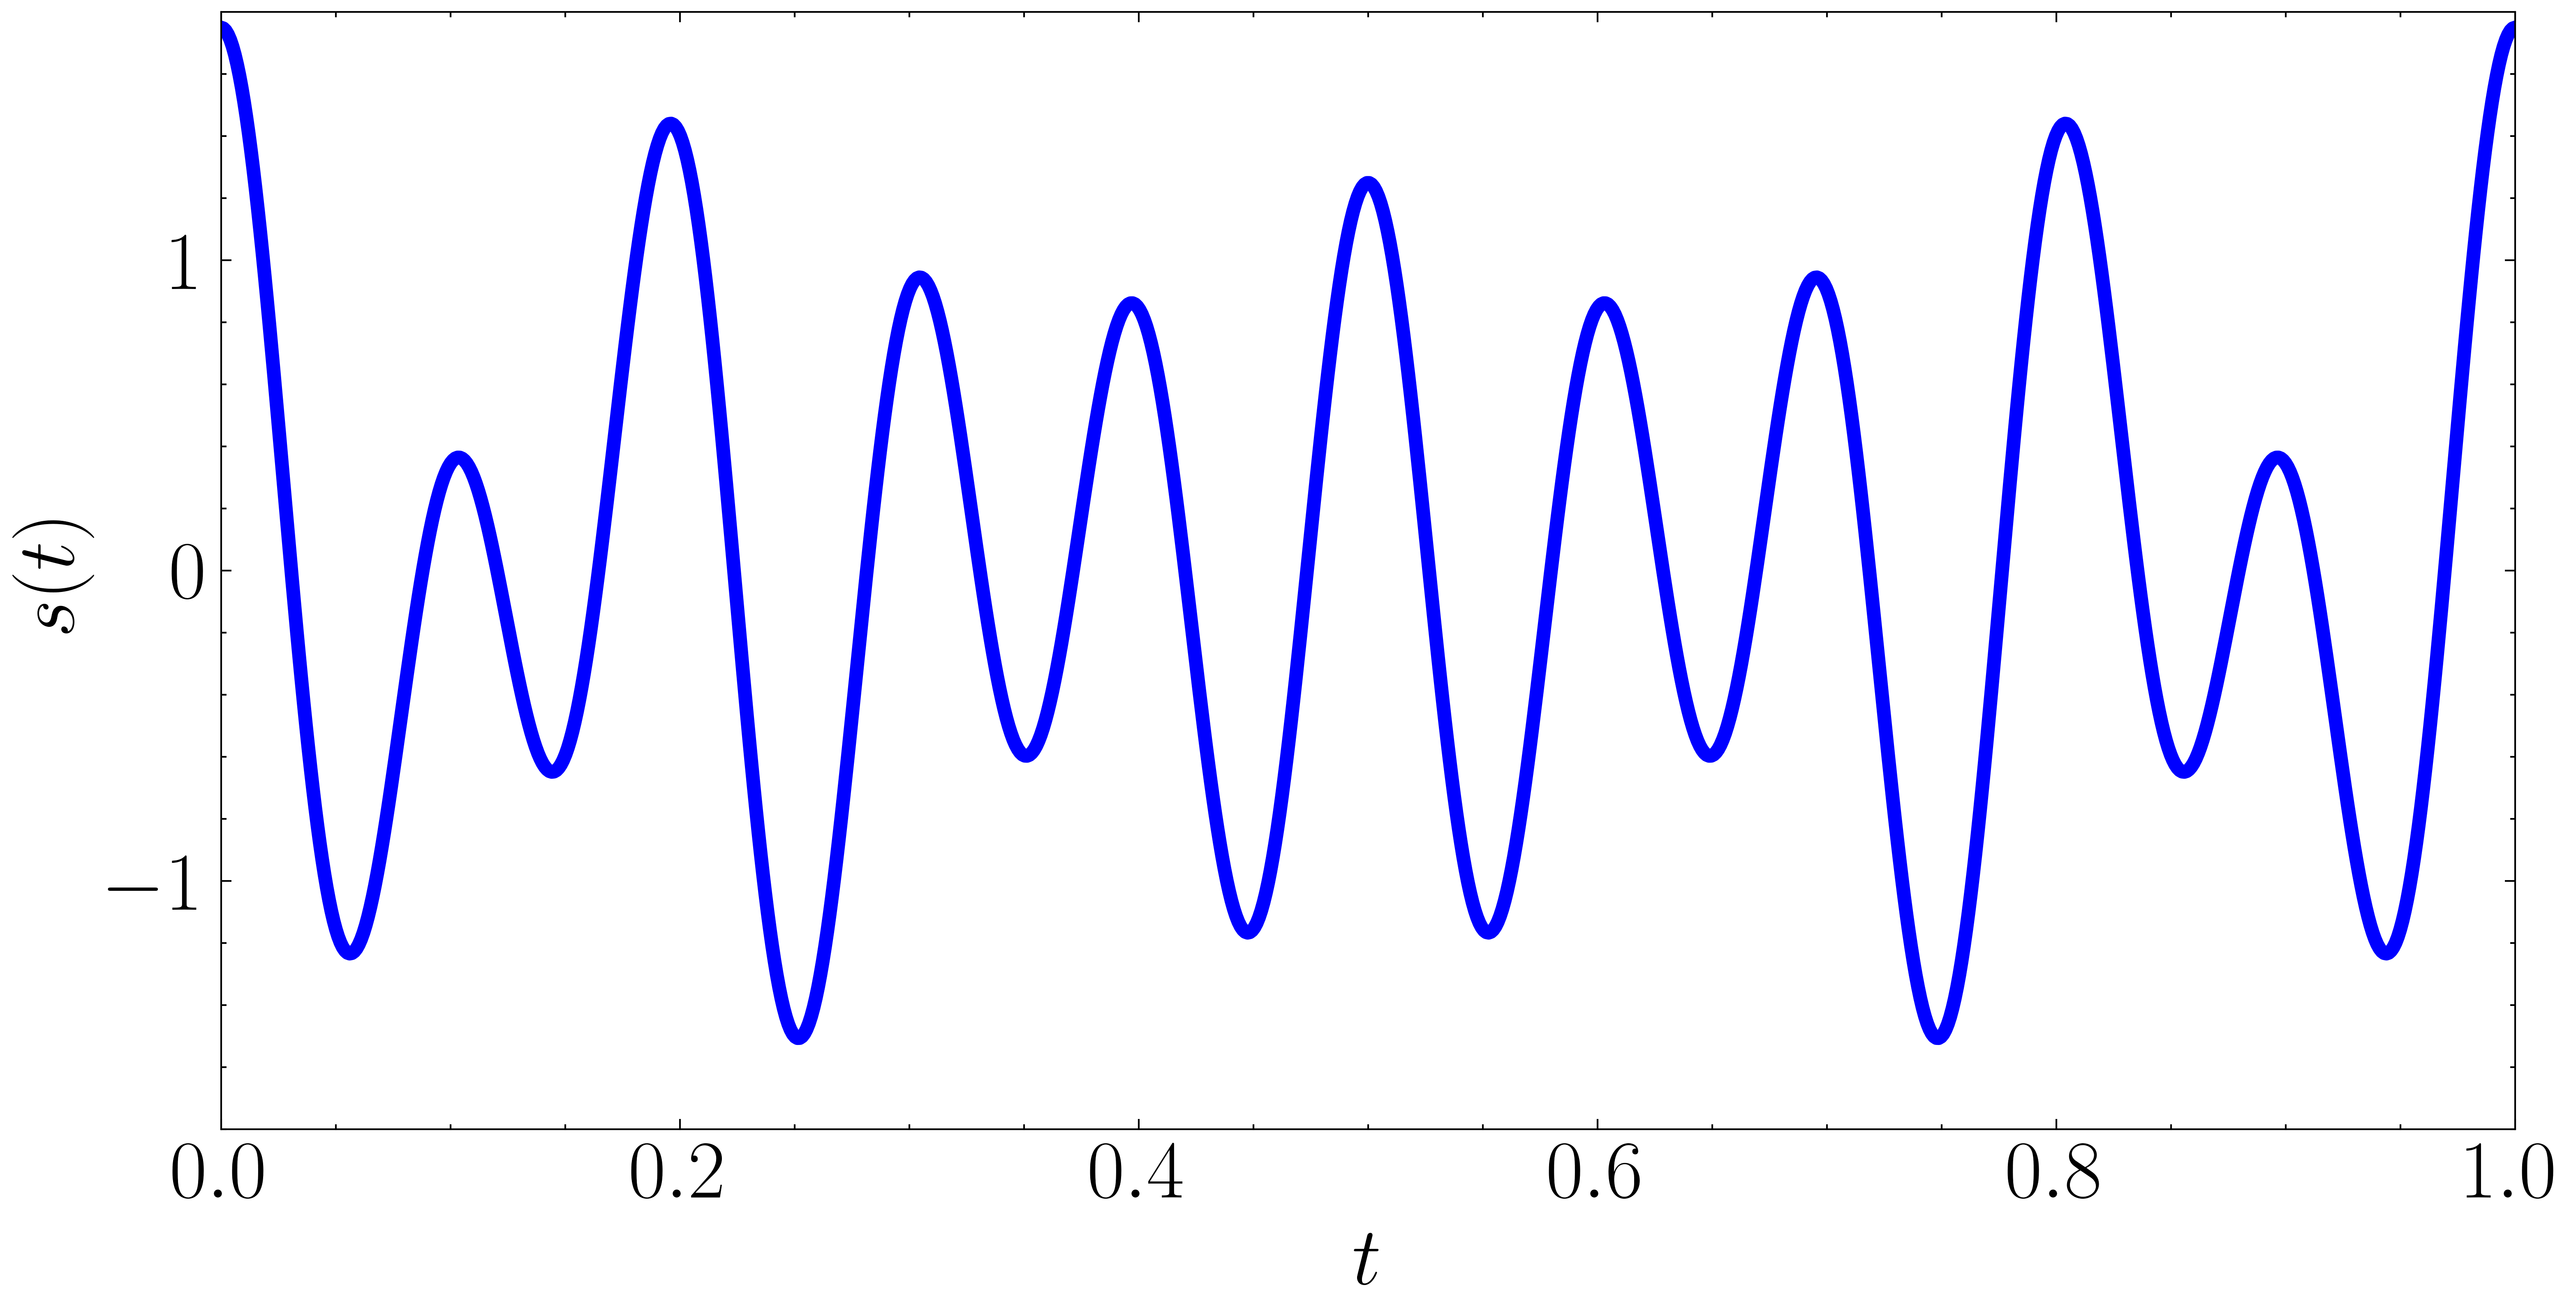

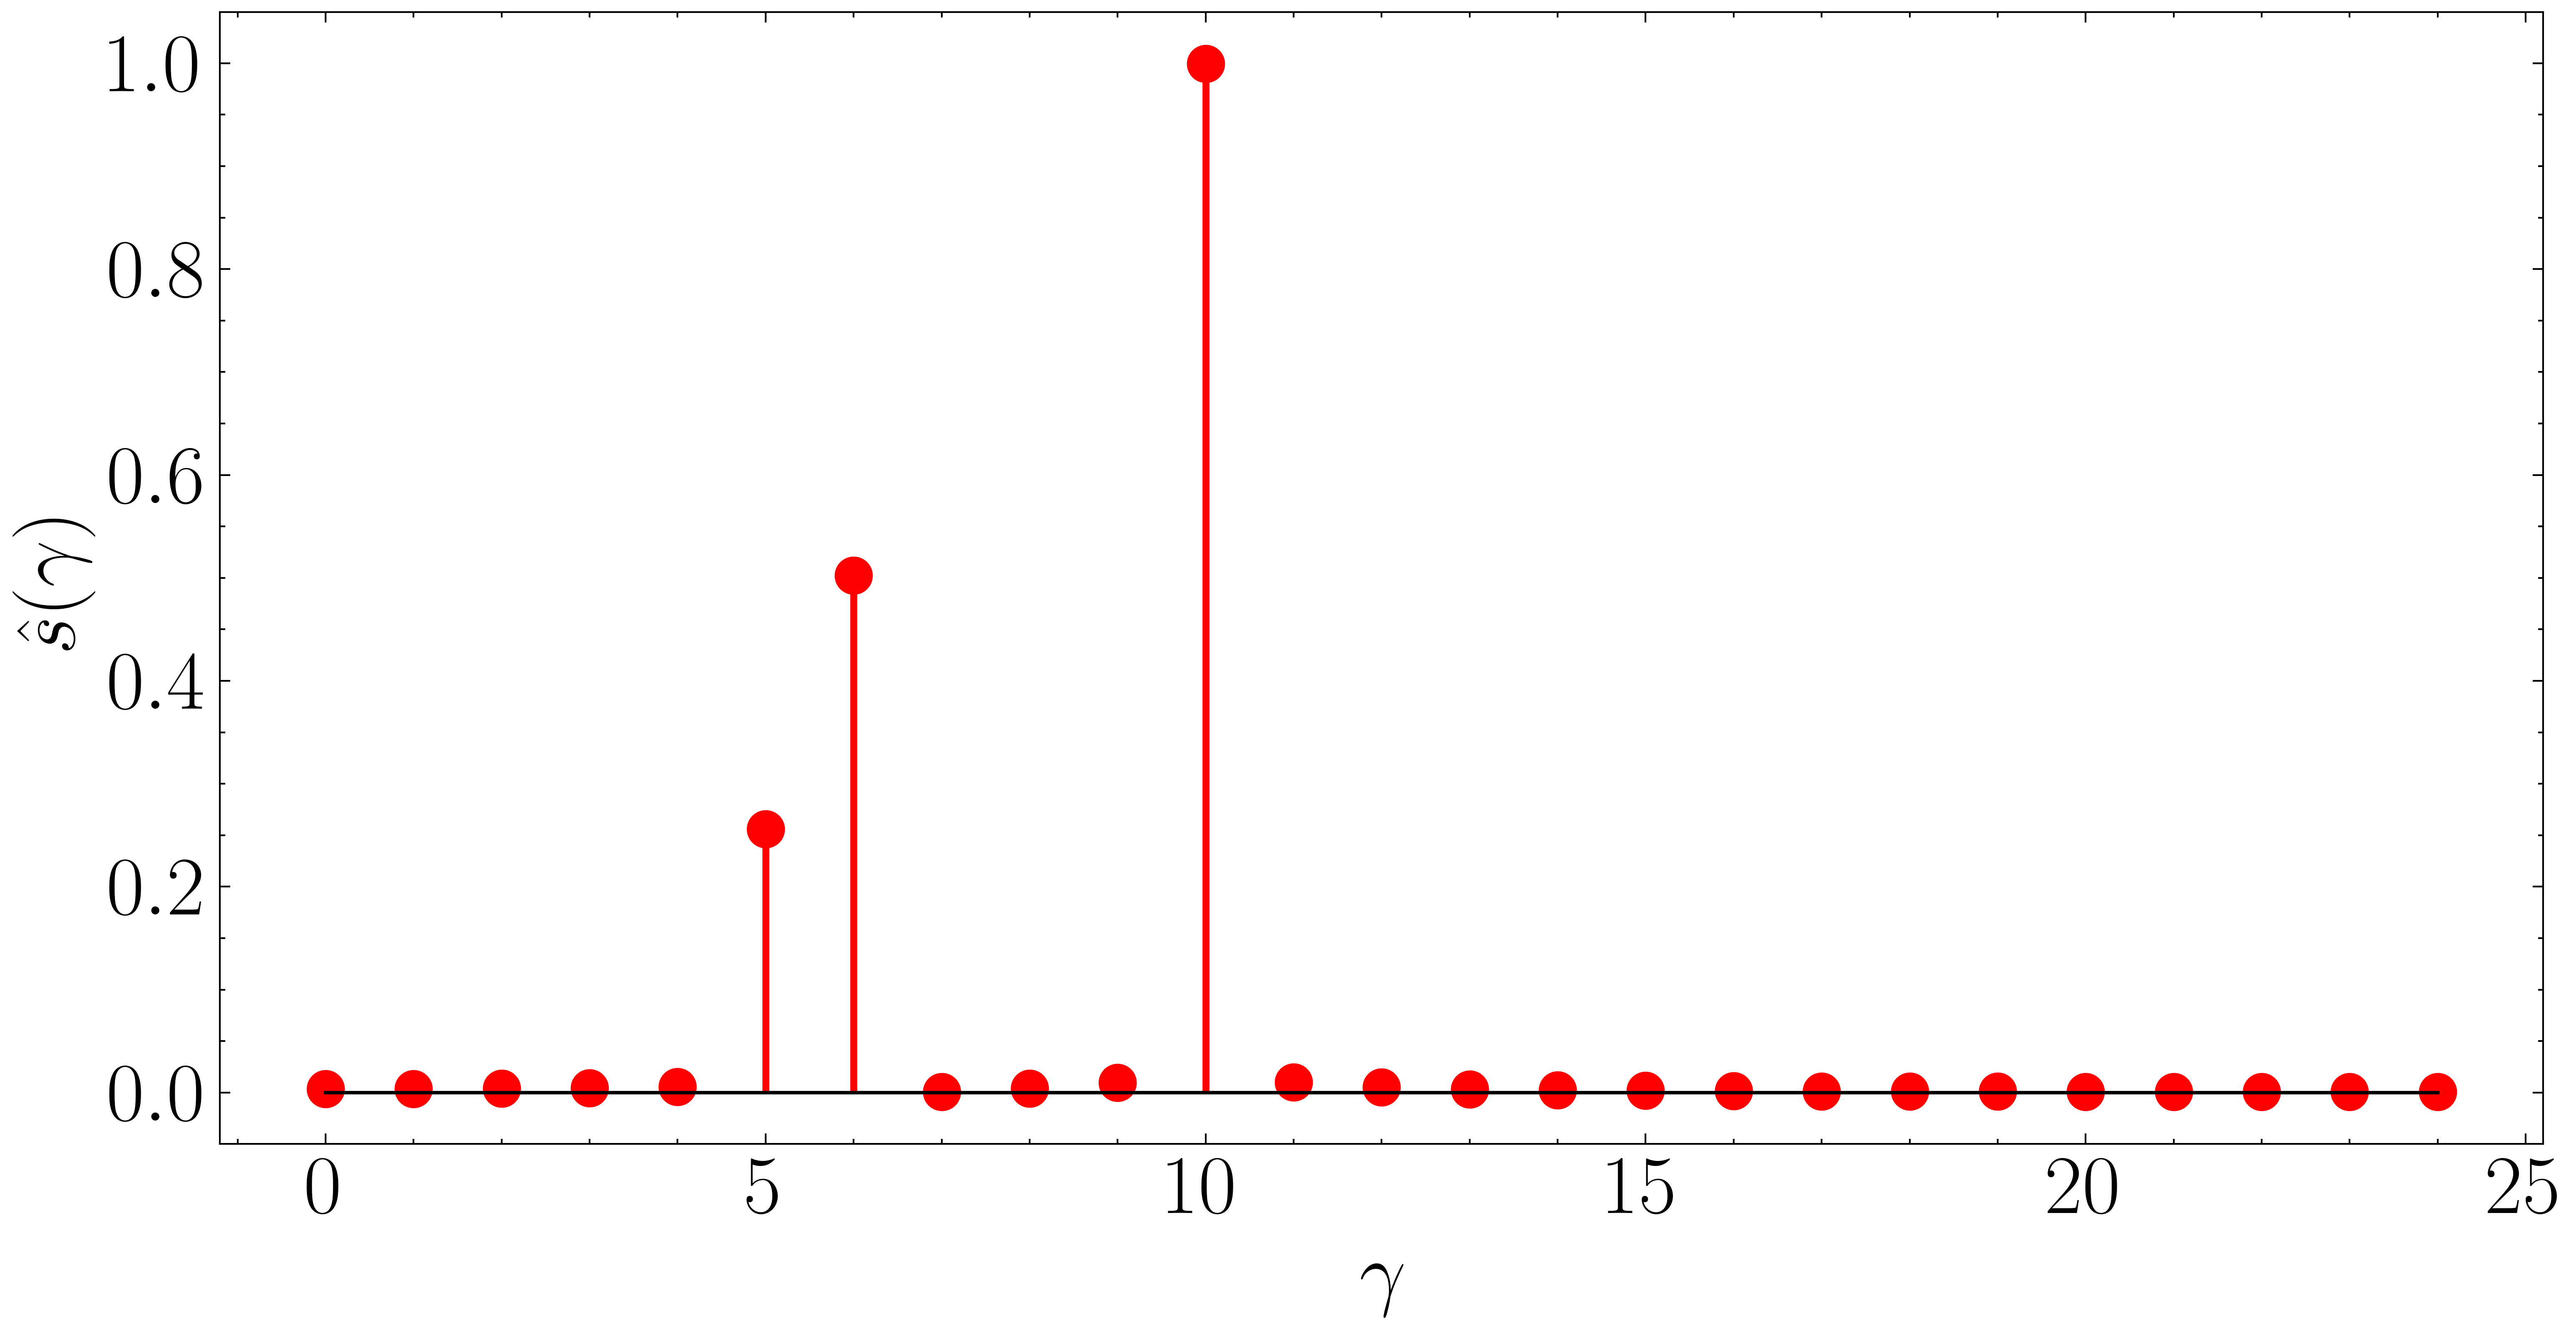

In [164]:
cosine = lambda A, f, t: A*np.cos(2*np.pi*f*t)

sum_of_sines = cosine(.25, 5, t_continuous) + cosine(.5, 6, t_continuous) \
            + cosine(1., 10, t_continuous)

def plot_spec(x, Fs, max_freq=None, ax=None, plot_colour='blue',
              xaxis_label=None, yaxis_label=None, legend_label=None):
    if ax is None:
        fig = plt.figure(figsize=(12,6))
        ax = plt.gca()
        
    C = int(len(x) / 2)
    if max_freq:
        C = int(C * max_freq / float(Fs) * 2) 
    X = np.abs(np.fft.fft(x)[0:C]) / 500
    N = Fs * np.arange(0,C) / len(x);
    
    markerline, stemlines, baseline = plt.stem(N, X, label=legend_label)
    plt.setp(stemlines, linewidth=2, color=plot_colour)
    plt.setp(markerline, marker='o', linewidth=2,
        markersize=10, markerfacecolor=plot_colour,
        mec=plot_colour)
    plt.setp(baseline, linewidth=1, color='k')
    
    plt.xlabel(xaxis_label)
    plt.ylabel(yaxis_label)
    if legend_label:
        plt.legend(ncol=3, loc="upper right", frameon=True,
                   framealpha=0.8, facecolor='white')

    plt.savefig(path+'diracsInFourierDomain' + '.pdf', format='pdf')
        
    return

fri_utils.plot_signal(t_continuous, sum_of_sines, line_width=4, xaxis_label=r'$t$',
    yaxis_label=r'$s(t)$', xlimits=[0,1], ylimits=[-1.8,1.8],
    save=path+'sumOfSines')

plot_spec(sum_of_sines, len(t_continuous), max_freq=25, plot_colour='red',
          xaxis_label=r"$\gamma$", yaxis_label=r'$\hat s(\gamma)$')

In [45]:
# %% SIGNAL RECOVERY

# Compute Fourier-series coefficients
forward_matrix = np.exp(1j*2*np.pi*np.outer(t_unif, np.arange(-K,K+1))/TAU)
fourier_series_coeffs = np.linalg.solve(forward_matrix, samples_unif)

# Estimate delays using Prony's method
annihilating_filter = fri_algos.prony_tls(fourier_series_coeffs, K)
tk_estimate = fri_algos.get_shifts(annihilating_filter, TAU)

# Estimate amplitudes using linear least-squares
swce_matrix = np.exp(-1j*2*np.pi*np.outer(np.arange(-K,K+1), tk_estimate)/TAU)
ak_estimate = N * np.matmul(np.linalg.pinv(swce_matrix),fourier_series_coeffs)

In [46]:
# %% COMPUTE ERRORS IN ESTIMATION

delay_estimation = np.linalg.norm(tk-tk_estimate)
amplitude_estimation = np.linalg.norm(ak-ak_estimate)

print(r'Total error in delay estimation: {0:.2e}'.format(delay_estimation))
print(r'Total error in amplitude estimation: {0:.2e}'.format(amplitude_estimation))

Total error in delay estimation: 4.18e-15
Total error in amplitude estimation: 1.27e-13


/opt/miniconda3/envs/sampling/lib/python3.7/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/opt/miniconda3/envs/sampling/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/miniconda3/envs/sampling/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


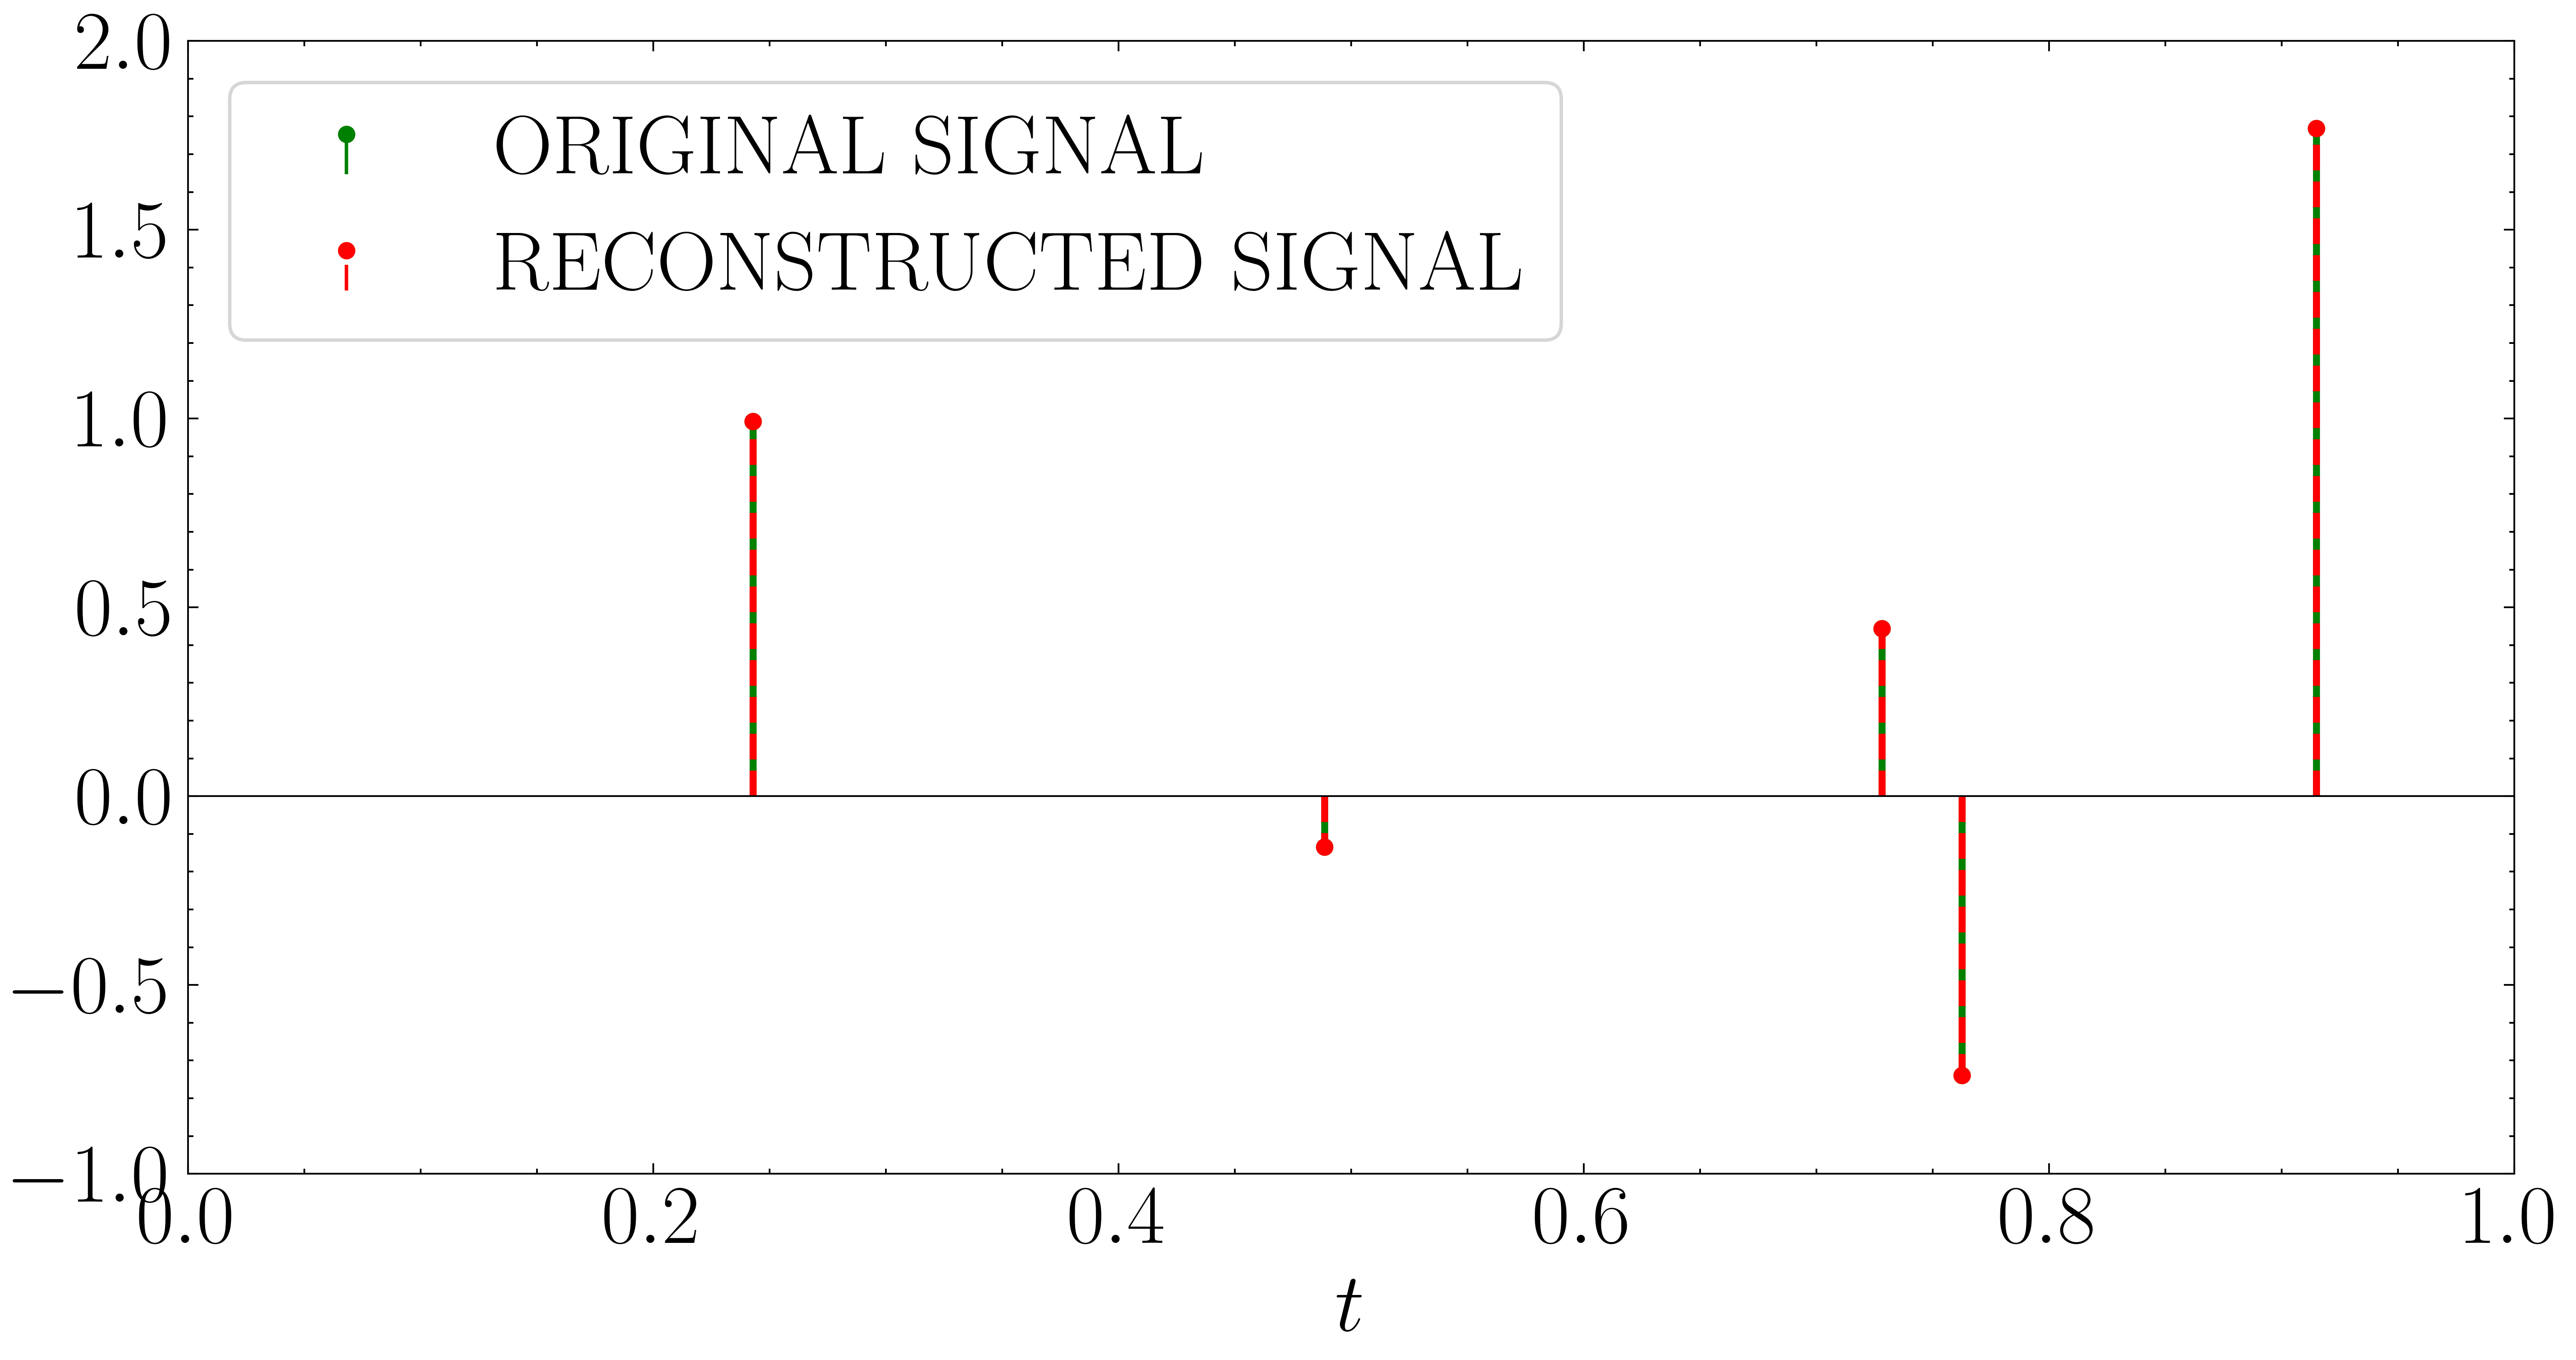

In [47]:
# %% PLOT RECONSTRUCTION

plt.figure(figsize=(12,6))
ax = plt.gca()
fri_utils.plot_diracs(tk, ak, ax=ax, plot_colour='green',
    legend_label=r'ORIGINAL SIGNAL', show=False)
fri_utils.plot_signal(t_continuous, np.zeros(len(t_continuous)), ax=ax,
    plot_colour='black', line_width=0.5, show=False)
fri_utils.plot_diracs(tk_estimate, ak_estimate, ax=ax, plot_colour='red',
    line_style='--', legend_label=r'RECONSTRUCTED SIGNAL',
    xlimits=[0,TAU], ylimits=[-1,2], xaxis_label=r'$t$', show=True,
    save=path+'sincPronyDiracReconstruction')